<a href="https://colab.research.google.com/github/sidraelx/sidharth-gupta-wasserstoff-AiInternTask/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!pip install torch torchvision transformers opencv-python-headless matplotlib pandas easyocr

In [73]:
import torch
import torchvision
from torchvision.datasets import VOCDetection

# Download and prepare the Pascal VOC dataset
dataset = VOCDetection(root=".", year='2012', image_set='train', download=True)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


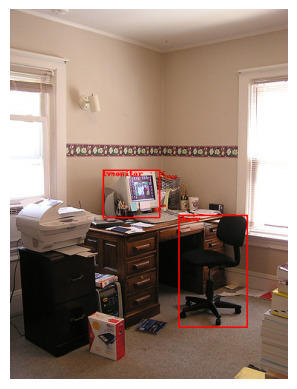

In [74]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Function to visualize the image and its bounding boxes
def visualize_voc_image(dataset, index):
    image, target = dataset[index]
    draw = ImageDraw.Draw(image)
    for obj in target['annotation']['object']:
        bbox = obj['bndbox']
        draw.rectangle([(int(bbox['xmin']), int(bbox['ymin'])), (int(bbox['xmax']), int(bbox['ymax']))], outline='red', width=2)
        draw.text((int(bbox['xmin']), int(bbox['ymin'])), obj['name'], fill='red')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize a random image from the dataset
index = random.randint(0, len(dataset) - 1)
visualize_voc_image(dataset, index)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


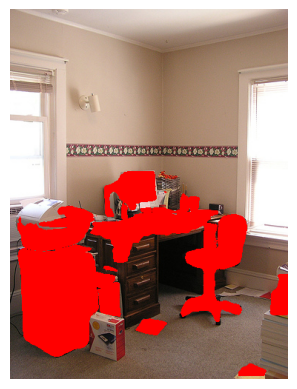

In [75]:
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define image preprocessing function
def preprocess_image(image):
    transform = T.Compose([
        T.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# Define function for segmentation
def segment_image(image):
    input_image = preprocess_image(image)
    with torch.no_grad():
        output = model(input_image)
    return output

# Visualize segmented image
def visualize_segments(image, output):
    image = np.array(image)
    masks = output[0]['masks'].mul(255).byte().cpu().numpy()
    for mask in masks:
        mask = mask[0]
        image[mask > 127] = [255, 0, 0]
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Input image
image, _ = dataset[index]
output = segment_image(image)
visualize_segments(image, output)

In [76]:
import os
import uuid

# Directory to save extracted objects
output_dir = 'extracted_voc_objects'
os.makedirs(output_dir, exist_ok=True)

# Define function to extract and save objects
def extract_objects(image, output):
    image = np.array(image)
    master_id = str(uuid.uuid4())  # Generate master_id outside the loop
    object_metadata = []
    masks = output[0]['masks'].mul(255).byte().cpu().numpy()
    for idx, mask in enumerate(masks):
        mask = mask[0]
        object_image = image * np.stack([mask, mask, mask], axis=2)
        object_id = str(uuid.uuid4())
        object_path = os.path.join(output_dir, f'{object_id}.png')
        Image.fromarray(object_image).save(object_path)
        object_metadata.append({
            'object_id': object_id,
            'master_id': master_id,  # Use the same master_id for all objects
            'object_path': object_path
        })
    return object_metadata

# Extract objects and save metadata
metadata = extract_objects(image, output)
print(metadata)

[{'object_id': '4e6d7595-8b21-4d9d-aa07-9d9553da8f64', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png'}, {'object_id': 'b81afbb2-49f0-4849-a52d-24de667d7969', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png'}, {'object_id': 'de97cbe4-a987-4c48-ab6b-08194e10ff44', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/de97cbe4-a987-4c48-ab6b-08194e10ff44.png'}, {'object_id': '92ff3eb7-b7f1-472a-8000-7be10276d698', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/92ff3eb7-b7f1-472a-8000-7be10276d698.png'}, {'object_id': '21270414-497d-41d4-a0d7-dbbd55dfed6f', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/21270414-497d-41d4-a0d7-dbbd55dfed6f.png'}, {'object_id': 'bc60246f-62dd-4cff-95ce-d4363bc88063', 

In [77]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Load the pre-trained CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

# Define function to identify and describe objects
def identify_objects(metadata):
    descriptions = []
    for item in metadata:
        object_image = Image.open(item['object_path'])
        inputs = processor(text=['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car','cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike','person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'], images=object_image, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        description = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car','cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike','person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'][probs.argmax()]
        item['description'] = description
        descriptions.append(item)
    return descriptions

# Identify objects and get descriptions
identified_metadata = identify_objects(metadata)
print(identified_metadata)


[{'object_id': '4e6d7595-8b21-4d9d-aa07-9d9553da8f64', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png', 'description': 'chair'}, {'object_id': 'b81afbb2-49f0-4849-a52d-24de667d7969', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png', 'description': 'tvmonitor'}, {'object_id': 'de97cbe4-a987-4c48-ab6b-08194e10ff44', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/de97cbe4-a987-4c48-ab6b-08194e10ff44.png', 'description': 'tvmonitor'}, {'object_id': '92ff3eb7-b7f1-472a-8000-7be10276d698', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/92ff3eb7-b7f1-472a-8000-7be10276d698.png', 'description': 'tvmonitor'}, {'object_id': '21270414-497d-41d4-a0d7-dbbd55dfed6f', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_vo

In [78]:
import easyocr

# Load the OCR model
reader = easyocr.Reader(['en'])

# Define function to extract text from objects
def extract_text(metadata):
    for item in metadata:
        object_image = Image.open(item['object_path'])
        text = reader.readtext(np.array(object_image), detail=0, paragraph=True)
        item['extracted_text'] = " ".join(text)
    return metadata

# Extract text from objects
text_metadata = extract_text(identified_metadata)
print(text_metadata)

[{'object_id': '4e6d7595-8b21-4d9d-aa07-9d9553da8f64', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png', 'description': 'chair', 'extracted_text': ''}, {'object_id': 'b81afbb2-49f0-4849-a52d-24de667d7969', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png', 'description': 'tvmonitor', 'extracted_text': ''}, {'object_id': 'de97cbe4-a987-4c48-ab6b-08194e10ff44', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/de97cbe4-a987-4c48-ab6b-08194e10ff44.png', 'description': 'tvmonitor', 'extracted_text': ''}, {'object_id': '92ff3eb7-b7f1-472a-8000-7be10276d698', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/92ff3eb7-b7f1-472a-8000-7be10276d698.png', 'description': 'tvmonitor', 'extracted_text': ''}, {'object_id': '21270414-497d-41d4-a0d7-dbbd55df

In [79]:
# Define function to summarize object attributes
def summarize_attributes(metadata):
    for item in metadata:
        attributes = {
            'description': item['description'],
            'extracted_text': item.get('extracted_text', ''),
            'object_path': item['object_path']
        }
        item['attributes'] = attributes
    return metadata

# Summarize attributes
summarized_metadata = summarize_attributes(text_metadata)
print(summarized_metadata)

[{'object_id': '4e6d7595-8b21-4d9d-aa07-9d9553da8f64', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png', 'description': 'chair', 'extracted_text': '', 'attributes': {'description': 'chair', 'extracted_text': '', 'object_path': 'extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png'}}, {'object_id': 'b81afbb2-49f0-4849-a52d-24de667d7969', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png', 'description': 'tvmonitor', 'extracted_text': '', 'attributes': {'description': 'tvmonitor', 'extracted_text': '', 'object_path': 'extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png'}}, {'object_id': 'de97cbe4-a987-4c48-ab6b-08194e10ff44', 'master_id': '9a6f5a36-7316-4e7f-b3da-02c92e953911', 'object_path': 'extracted_voc_objects/de97cbe4-a987-4c48-ab6b-08194e10ff44.png', 'description': 'tvmonitor', 'extracted_text': '

In [80]:
import json

# Define function to map data
def map_data(metadata):
    mapped_data = {}
    for item in metadata:
        master_id = item['master_id']
        if master_id not in mapped_data:
            mapped_data[master_id] = []
        mapped_data[master_id].append(item['attributes'])
    return mapped_data

# Map data
mapped_data = map_data(summarized_metadata)
print(json.dumps(mapped_data, indent=4))

{
    "9a6f5a36-7316-4e7f-b3da-02c92e953911": [
        {
            "description": "chair",
            "extracted_text": "",
            "object_path": "extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-9d9553da8f64.png"
        },
        {
            "description": "tvmonitor",
            "extracted_text": "",
            "object_path": "extracted_voc_objects/b81afbb2-49f0-4849-a52d-24de667d7969.png"
        },
        {
            "description": "tvmonitor",
            "extracted_text": "",
            "object_path": "extracted_voc_objects/de97cbe4-a987-4c48-ab6b-08194e10ff44.png"
        },
        {
            "description": "tvmonitor",
            "extracted_text": "",
            "object_path": "extracted_voc_objects/92ff3eb7-b7f1-472a-8000-7be10276d698.png"
        },
        {
            "description": "tvmonitor",
            "extracted_text": "",
            "object_path": "extracted_voc_objects/21270414-497d-41d4-a0d7-dbbd55dfed6f.png"
        },
        {
           

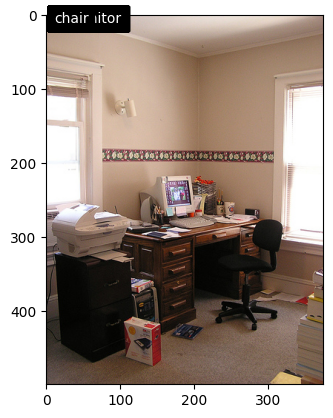

,master_id,description,extracted_text
0,9a6f5a36-7316-4e7f-b3da-02c92e953911,chair,
1,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
2,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
3,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
4,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
5,9a6f5a36-7316-4e7f-b3da-02c92e953911,cow,
6,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
7,9a6f5a36-7316-4e7f-b3da-02c92e953911,bottle,
8,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,
9,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,


In [81]:
import pandas as pd

# Define function to generate final output
def generate_output(metadata, mapped_data, image):
    original_image = image
    plt.imshow(original_image)

    # Annotate image with descriptions and verify
    for item in metadata:
        object_image = Image.open(item['object_path'])
        description = item['description']
        master_id = item['master_id']

        # Verification step
        matching_objects = [obj for obj in mapped_data[master_id] if obj['description'] == description]
        if matching_objects:
            plt.annotate(description, (10, 10), color='white', backgroundcolor='black')
        else:
            print(f"Warning: No matching object found for master_id {master_id} and description {description}")

    plt.show()

    # Create summary table
    summary_table = []
    for master_id, objects in mapped_data.items():
        for obj in objects:
            summary_table.append({
                'master_id': master_id,
                'description': obj['description'],
                'extracted_text': obj['extracted_text']
            })
    df = pd.DataFrame(summary_table)

    # Reformat the table
    styled_df = df.style.set_properties(**{'text-align': 'left'}) \
                       .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

    # Display the styled table
    display(styled_df)
# Generate output
generate_output(summarized_metadata, mapped_data, image)

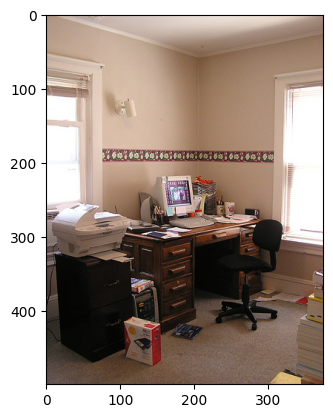

,master_id,description,extracted_text,object_path
0,9a6f5a36-7316-4e7f-b3da-02c92e953911,chair,,extracted_voc_objects/4e6d7595-8b21-4d9d-aa07-...
1,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/b81afbb2-49f0-4849-a52d-...
2,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/de97cbe4-a987-4c48-ab6b-...
3,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/92ff3eb7-b7f1-472a-8000-...
4,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/21270414-497d-41d4-a0d7-...
5,9a6f5a36-7316-4e7f-b3da-02c92e953911,cow,,extracted_voc_objects/bc60246f-62dd-4cff-95ce-...
6,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/6b3ed762-9c86-4ca5-87c6-...
7,9a6f5a36-7316-4e7f-b3da-02c92e953911,bottle,,extracted_voc_objects/f4dde07b-2bcf-43b8-bbf4-...
8,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/e552688d-9479-4f78-83ab-...
9,9a6f5a36-7316-4e7f-b3da-02c92e953911,tvmonitor,,extracted_voc_objects/fad02bdc-4032-4269-9613-...


In [82]:
import pandas as pd

def generate_output(metadata, mapped_data, image):
    # Display the original image
    plt.imshow(image)
    plt.show()

    # Create a list to store the summary data
    summary_table = []
    for master_id, objects in mapped_data.items():
        for obj in objects:
            summary_table.append({
                'master_id': master_id,
                'description': obj['description'],
                'extracted_text': obj['extracted_text'],
                'object_path': obj['object_path']
            })

    # Create a Pandas DataFrame from the summary data
    df = pd.DataFrame(summary_table)

    # Display the DataFrame as a table
    display(df)

# Assuming 'summarized_metadata', 'mapped_data', and 'image' are already defined
generate_output(summarized_metadata, mapped_data, image)